## SimCLR Training

In [2]:
import os
import pickle
import scipy
import datetime
import numpy as np
import tensorflow as tf
import simclr_utitlities
import transformations
import simclr_models
import sys
import matplotlib.pyplot as plt
sys.path.append('../../')   # Add parent directory to Python path

seed = 1
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
# Parameters
working_directory = "../../models/"
window_size = 50
input_shape = (window_size, 3)
batch_size = 512
#Number of samples processed together in one training step. Larger batch sizes can speed up training but require more memory.
decay_steps = 1000
#Number of steps after which the learning rate decays (used for learning rate scheduling).
epochs = 200
temperature = 0.1
#A parameter for the SimCLR loss function that controls how sharply similarities are measured.
transform_funcs = [
    # transformations.scaling_transform_vectorized, # Use Scaling trasnformation
    transformations.rotation_transform_vectorized # Use rotation trasnformation
]
# List of data augmentation functions to apply to the input data. Here, only rotation is used.
transformation_function = simclr_utitlities.generate_composite_transform_function_simple(transform_funcs)

0 <function rotation_transform_vectorized at 0x000001454300BBA0>


In [ ]:
# trasnformation_indices = [2] # Use rotation trasnformation only
# trasnformation_indices = [1, 2] # Use Scaling and rotation trasnformation

# trasnform_funcs_vectorized = [
#     transformations.noise_transform_vectorized, 
#     transformations.scaling_transform_vectorized, 
#     transformations.rotation_transform_vectorized, 
#     transformations.negate_transform_vectorized, 
#     transformations.time_flip_transform_vectorized, 
#     transformations.time_segment_permutation_transform_improved, 
#     transformations.time_warp_transform_low_cost, 
#     transformations.channel_shuffle_transform_vectorized
# ]
# transform_funcs_names = ['noised', 'scaled', 'rotated', 'negated', 'time_flipped', 'permuted', 'time_warped', 'channel_shuffled']

In [4]:
# Time
start_time = datetime.datetime.now()
start_time_str = start_time.strftime("%Y%m%d-%H%M%S")
#Formats the date and time as a string like 20250827-153045 (for filenames, logs, etc.).
tf.keras.backend.set_floatx('float32')
#Sets TensorFlow to use 32-bit floating point numbers for all computations (standard for deep learning).

In [20]:
# Load data
with open('../../data/TrainTest_one/X_train_normalized.pkl', 'rb') as f:
    np_train_data = pickle.load(f)
with open('../../data/TrainTest_one/y_train_onehot.pkl', 'rb') as f:
    np_train_labels = pickle.load(f)

In [22]:
# Create a cosine-decayed learning rate schedule and SGD optimizer for training.
lr_decayed_fn = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=0.1, decay_steps=decay_steps)
optimizer = tf.keras.optimizers.SGD(lr_decayed_fn)

# Optionally, you can use a combined transformation function for data augmentation.
# transformation_function = simclr_utitlities.generate_combined_transform_function(trasnform_funcs_vectorized, indices=trasnformation_indices)

# Build the base model and attach the SimCLR head for contrastive learning.
base_model = simclr_models.create_base_model(input_shape, model_name="base_model")
simclr_model = simclr_models.attach_simclr_head(base_model)
simclr_model.summary()

# Train the SimCLR model using the specified transformation function and optimizer.
trained_simclr_model, epoch_losses = simclr_utitlities.simclr_train_model(
    simclr_model, np_train_data, optimizer, batch_size, transformation_function,
    temperature=temperature, epochs=epochs, is_trasnform_function_vectorized=True, verbose=1
)

# Save the trained SimCLR model to disk for later use.
simclr_model_save_path = f"{working_directory}{start_time_str}_simclr.hdf5"
trained_simclr_model.save(simclr_model_save_path)

Model: "base_model_simclr"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 50, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 27, 32)         │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 27, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 12, 64)         │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 5, 96)          │        49,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 96)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         6,450 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 148,594 (580.45 KB)

 Trainable params: 148,594 (580.45 KB)

 Non-trainable params: 0 (0.00 B)

epoch: 1 loss: 12.012
epoch: 2 loss: 11.575
epoch: 3 loss: 10.533
epoch: 4 loss: 11.343
epoch: 5 loss: 10.764
epoch: 6 loss: 9.778
epoch: 7 loss: 10.722
epoch: 8 loss: 9.792
epoch: 9 loss: 9.687
epoch: 10 loss: 10.215
epoch: 11 loss: 9.361
epoch: 12 loss: 9.964
epoch: 13 loss: 9.294
epoch: 14 loss: 9.884
epoch: 15 loss: 9.801
epoch: 16 loss: 9.328
epoch: 17 loss: 9.250
epoch: 18 loss: 9.377
epoch: 19 loss: 10.751
epoch: 20 loss: 9.422
epoch: 21 loss: 8.763
epoch: 22 loss: 9.533
epoch: 23 loss: 9.473
epoch: 24 loss: 8.837
epoch: 25 loss: 8.956
epoch: 26 loss: 8.637
epoch: 27 loss: 8.657
epoch: 28 loss: 8.501
epoch: 29 loss: 8.445
epoch: 30 loss: 7.895
epoch: 31 loss: 8.557
epoch: 32 loss: 8.801
epoch: 33 loss: 7.630
epoch: 34 loss: 8.413
epoch: 35 loss: 7.673
epoch: 36 loss: 8.449
epoch: 37 loss: 8.423
epoch: 38 loss: 7.904
epoch: 39 loss: 7.493
epoch: 40 loss: 7.570
epoch: 41 loss: 7.319
epoch: 42 loss: 7.541
epoch: 43 loss: 7.466
epoch: 44 loss: 7.570
epoch: 45 loss: 7.327
epoch: 46 l

epoch: 200 loss: 4.149


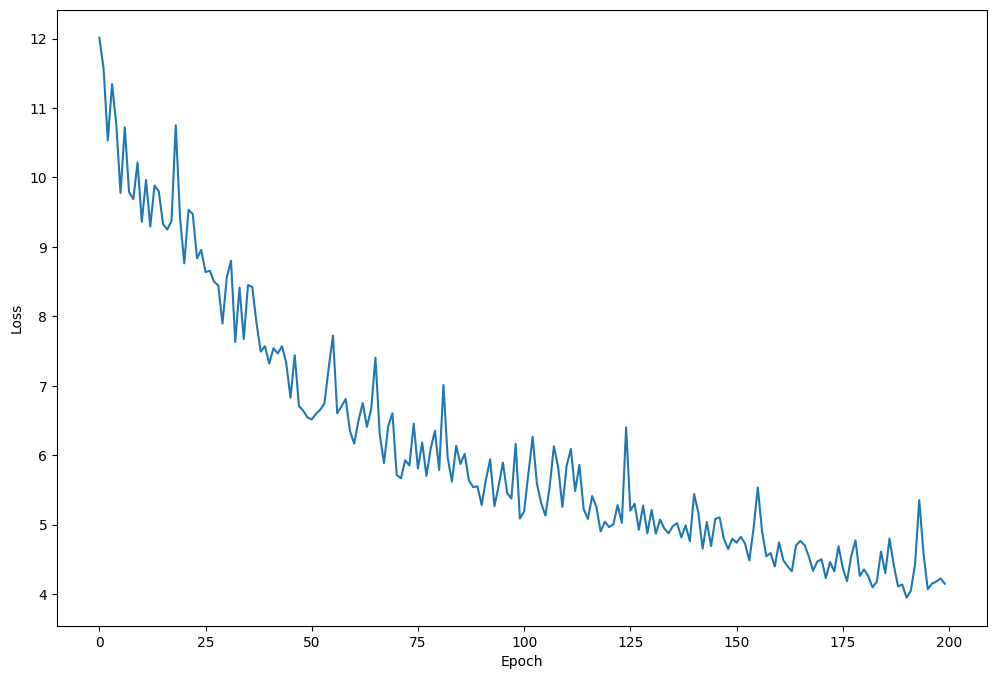

In [24]:
plt.figure(figsize=(12,8))
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

## Fine-tuning and Evaluation

### Linear Model

In [ ]:
total_epochs = 50
batch_size = 200
tag = "linear_eval"

simclr_model = tf.keras.models.load_model(simclr_model_save_path)
linear_evaluation_model = simclr_models.create_linear_model_from_base_model(simclr_model, output_shape, intermediate_layer=7)

linear_eval_best_model_file_name = f"{working_directory}{start_time_str}_simclr_{tag}.hdf5"
best_model_callback = tf.keras.callbacks.ModelCheckpoint(linear_eval_best_model_file_name,
    monitor='val_loss', mode='min', save_best_only=True, save_weights_only=False, verbose=0
)

training_history = linear_evaluation_model.fit(
    x = np_train_data,
    y = np_train_labels,
    batch_size=batch_size,
    shuffle=True,
    epochs=total_epochs,
    callbacks=[best_model_callback],
    validation_data=np_val,
)

linear_eval_best_model = tf.keras.models.load_model(linear_eval_best_model_file_name)

print("Model with lowest validation Loss:")
print(simclr_utitlities.evaluate_model_simple(linear_eval_best_model.predict(np_test[0]), np_test[1], return_dict=True))
print("Model in last epoch")
print(simclr_utitlities.evaluate_model_simple(linear_evaluation_model.predict(np_test[0]), np_test[1], return_dict=True))
